<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/classification_semantic_segmentation.png" width="600"></center>

Выделяют следующие задачи:
- **Классификация** (Classification). Нужно определить класс объекта на изображении, но при этом расположение объекта не важно.
- **Детектирование** (Object Detection). Нужно определить индивидуальные **объекты** и **выделить области** (например, прямоугольники) в которых они локализованы. Например: подсчет количества китов на спутниковом снимке.
- **Сегментация** (Segmentation). Нужно определить, какие фрагменты изображения принадлежат определенным объектам/классам. При этом важно знать не только **расположение**, но и **границу объектов**.
    - **Семантическая сегментация** (Semantic segmentation) — не выделяет индивидуальные объекты, **важен только тип (класс) объекта**, которым занят конкретный пиксель. Например: определение площади леса на спутниковом снимке.
    - **Сегментация экземпляров** (Instance segmentation) — выделяет **индивидуальные объекты** и их границы. Например: выделение клеток на снимке с электронного микроскопа.

## Датасет COCO (Common Objects in Context)

Прежде чем говорить о способах решения этих задач, надо разобраться с форматами входных данных. Сделаем это на примере датасета [COCO 🛠️[doc]](https://cocodataset.org/).

**COCO** — один из наиболее популярных **датасетов**, содержащий данные для **сегментации и детектирования**. Он содержит более трёхсот тысяч изображений, большая часть из которых размечена и содержит следующую информацию:
- категории;
- маски;
- ограничивающие боксы (*bounding boxes*);
- описания (*captions*);
- ключевые точки (*keypoints*);
- и многое другое.

Формат разметки изображений, использованный в этом датасете, нередко используется и в других наборах данных. Как правило, он упоминается просто как "COCO format".

[[blog] ✏️ Как создать свой COCO датасет с нуля](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch)

Загрузим датасет:

In [ ]:
# !wget -qN "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
!wget -qN "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/annotations_trainval2017.zip"
!unzip -qn annotations_trainval2017.zip

Для работы с датасетом используется пакет `pycocotools`.

Загрузим фрагмент датасета COCO для валидации (он меньше по размеру) с аннотацией по сегментации/детекции (`instances`), чтобы познакомиться с его структурой:

In [ ]:
from pycocotools.coco import COCO

coco = COCO("annotations/instances_val2017.json")  # load annotations into memory

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!


### Пример объекта

Рассмотрим формат аннотаций на примере одной категории. Узнаем индекс категории `cow` и посчитаем, сколько в датасете картинок с коровами (`catNms` — названия категорий):

In [ ]:
catIds = coco.getCatIds(catNms=["cow"])  #  Find category ID by tag
print("Category ID(cow) =", catIds)

imgIds = coco.getImgIds(catIds=catIds)  # Filtering dataset by category ID
print("All images: %i" % len(imgIds))

Category ID(cow) = [21]
All images: 87


Рассмотрим метаданные для первого изображения из категории:

In [ ]:
img_list = coco.loadImgs(imgIds[0])  # Load image metadata by image ID
img_metadata = img_list[0]
img_metadata

{'license': 2,
 'file_name': '000000435206.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000435206.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-17 18:11:57',
 'flickr_url': 'http://farm8.staticflickr.com/7193/6969816407_5584aa0172_z.jpg',
 'id': 435206}

В метаданных есть информация о лицензии, под которой распространяется изображение, название файла с изображением, ссылки для загрузки, информация о размере изображения и т.д.

Скачаем и визуализируем изображение:

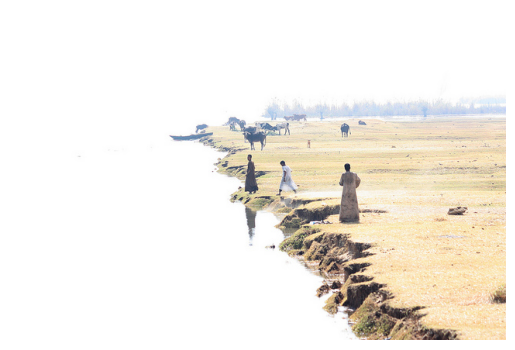

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO


def coco2pil(url):
    response = requests.get(url)  # get image by image url
    return Image.open(BytesIO(response.content))


I = coco2pil(img_metadata["coco_url"])
plt.axis("off")
plt.imshow(I)
plt.show()

Видим, что на изображении действительно присутствует корова.

### Категории в COCO

У категорий в COCO есть особенности. Давайте посмотрим, сколько всего категорий:

In [ ]:
cats = coco.loadCats(coco.getCatIds())  # Loading categories for all IDs of categories
print(f"Number of categories = {len(cats)}")

Number of categories = 80


Посмотрим на последнюю в списке категорий запись:

In [ ]:
print(f"Last category: {cats[-1]}")

Last category: {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}


Видим, что id последней категории равен 90, при этом всего категорий 80. Распечатаем id и имена категорий.

In [ ]:
cats = coco.loadCats(coco.getCatIds())  # Loading categories for all IDs of categories
num2cat = {cat["id"]: cat["name"] for cat in cats}
print("COCO categories:\n")

for i in range(91):
    if i in num2cat:
        name = num2cat[i]
    else:
        name = "---"
    print(f"{i:2}. {name:20}", end="")

    if not i % 6:
        print("\n")

COCO categories:

 0. ---                 

 1. person               2. bicycle              3. car                  4. motorcycle           5. airplane             6. bus                 

 7. train                8. truck                9. boat                10. traffic light       11. fire hydrant        12. ---                 

13. stop sign           14. parking meter       15. bench               16. bird                17. cat                 18. dog                 

19. horse               20. sheep               21. cow                 22. elephant            23. bear                24. zebra               

25. giraffe             26. ---                 27. backpack            28. umbrella            29. ---                 30. ---                 

31. handbag             32. tie                 33. suitcase            34. frisbee             35. skis                36. snowboard           

37. sports ball         38. kite                39. baseball bat        40. base

В COCO:
- Некоторые номера категорий не заняты. Это сделано специально для совместимости с некоторыми другими аналогичными датасетами (например, PASCAL Visual Object Classes): номера классов в этих датасетах совпадают.
- Категория `id = 0` используется для обозначения класса фона.

Также существуют супер-категории. Например, машину, автобус и самолет объединяют в средства передвижения.

In [ ]:
print(f"categories[2]: {cats[2]}")
print(f"categories[3]: {cats[3]}")

categories[2]: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
categories[3]: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}


In [ ]:
from collections import defaultdict

super_cat = defaultdict(list)
for cat in cats:
    super_cat[cat["supercategory"]].append(cat["name"])

print(f"COCO supercategories:")
for i in super_cat:
    print(f"\t{i:10}: {super_cat[i]}")

COCO supercategories:
	person    : ['person']
	vehicle   : ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']
	outdoor   : ['traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
	animal    : ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
	accessory : ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase']
	sports    : ['frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket']
	kitchen   : ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl']
	food      : ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake']
	furniture : ['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet']
	electronic: ['tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone']
	appliance : ['microwave', 'oven', 'toaster', 'sink', 'refrigerator']
	indoor    : ['book', 'clock', 'vase', 'sc

### Разметка данных

Помимо метаданных нам доступна [разметка 🛠️[doc]](https://cocodataset.org/#format-data). Давайте её загрузим и отобразим.

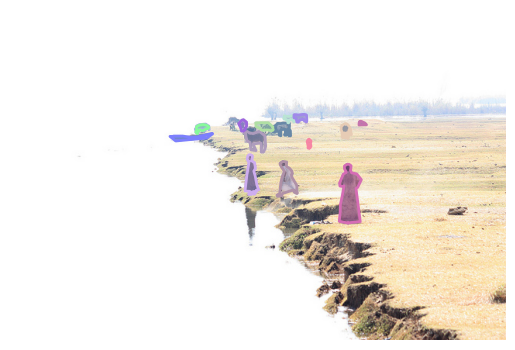

In [ ]:
annIds = coco.getAnnIds(imgIds=img_metadata["id"])  # Get annotation ID by image ID
anns = coco.loadAnns(annIds)  # Load annotation

plt.imshow(I)
plt.axis("off")
coco.showAnns(anns)  # Show instances
plt.show()

На изображении можно увидеть разметку пикселей изображения по объектам. Люди и коровы выделены по одному.


Посмотрим, из чего состоит разметка.

In [ ]:
def dump_anns(anns):
    for i, a in enumerate(anns):
        print(f"\n#{i}")
        for k in a.keys():
            if k == "category_id" and num2cat.get(a[k], None):
                print(k, ": ", a[k], num2cat[a[k]])  # Show cat. name
            else:
                print(k, ": ", a[k])


dump_anns(anns)


#0
segmentation :  [[385.74, 174.24, 386.02, 179.04, 386.73, 178.48, 387.86, 176.5, 387.15, 172.83, 387.86, 169.73, 385.6, 167.48, 384.47, 167.76, 382.92, 170.16, 384.33, 176.78, 384.05, 178.9, 385.46, 178.76]]
area :  38.56105000000001
iscrowd :  0
image_id :  435206
bbox :  [382.92, 167.48, 4.94, 11.56]
category_id :  20 sheep
id :  61622

#1
segmentation :  [[301.68, 159.23, 305.5, 157.32, 308.37, 159.23, 313.15, 160.18, 320.79, 157.32, 323.65, 159.23, 328.43, 163.05, 329.38, 176.42, 328.43, 180.24, 326.52, 184.06, 323.65, 184.06, 323.65, 172.6, 320.79, 172.6, 313.15, 173.56, 316.97, 182.15, 310.28, 181.2, 309.32, 171.65, 305.5, 169.73, 302.64, 159.23]]
area :  422.9528500000006
iscrowd :  0
image_id :  435206
bbox :  [301.68, 157.32, 27.7, 26.74]
category_id :  21 cow
id :  73046

#2
segmentation :  [[435.43, 148.75, 437.85, 151.83, 439.28, 156.24, 438.95, 159.1, 439.83, 159.65, 439.94, 161.52, 438.51, 161.74, 437.85, 159.43, 437.52, 156.24, 436.97, 155.14, 436.09, 160.64, 435.76,

Заметим, что аннотация изображения состоит из описаний нескольких объектов, каждое из которых содержит следующую информацию:
* `segmentation` — последовательность пар чисел ($x$, $y$) — координат каждой из вершин "оболочки" объекта;
* `area` — площадь объекта;
* `iscrowd` — несколько объектов, например, толпа людей, в этом случае информация о границах объекта (маска) хранится в формате [RLE 📚[wiki]](https://en.wikipedia.org/wiki/Run-length_encoding);
* `image_id` — идентификатор изображения, к которому принадлежит описываемый объект;
* `bbox` — ограничивающий прямоугольник;
* `category_id` — идентификатор категории, к которой относится данный объект;
* `id` — идентификатор самого объекта.

То есть **информации о категории** для каждого объекта **есть в разметке**.

Попробуем посмотреть на пример, в котором `iscrowd = True`.


#0
segmentation :  {'counts': [272, 2, 4, 4, 4, 4, 2, 9, 1, 2, 16, 43, 143, 24, 5, 8, 16, 44, 141, 25, 8, 5, 17, 44, 140, 26, 10, 2, 17, 45, 129, 4, 5, 27, 24, 5, 1, 45, 127, 38, 23, 52, 125, 40, 22, 53, 123, 43, 20, 54, 122, 46, 18, 54, 121, 54, 12, 53, 119, 57, 11, 53, 117, 59, 13, 51, 117, 59, 13, 51, 117, 60, 11, 52, 117, 60, 10, 52, 118, 60, 9, 53, 118, 61, 8, 52, 119, 62, 7, 52, 119, 64, 1, 2, 2, 51, 120, 120, 120, 101, 139, 98, 142, 96, 144, 93, 147, 90, 150, 87, 153, 85, 155, 82, 158, 76, 164, 66, 174, 61, 179, 57, 183, 54, 186, 52, 188, 49, 191, 47, 193, 21, 8, 16, 195, 20, 13, 8, 199, 18, 222, 17, 223, 16, 224, 16, 224, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 15, 225, 14, 226, 14, 226, 14, 39, 1, 186, 14, 39, 3, 184, 14, 39, 4, 183, 13, 40, 6, 181, 14, 39, 7, 180, 14, 39, 9, 178, 14, 39, 10, 177, 14, 39, 11, 176, 14, 38, 14, 174, 14, 36, 19, 171, 15, 33, 32, 160, 16, 30, 35, 159, 18, 26, 38, 158, 19, 23, 41, 157, 20, 19, 45, 156, 21, 15, 48, 1

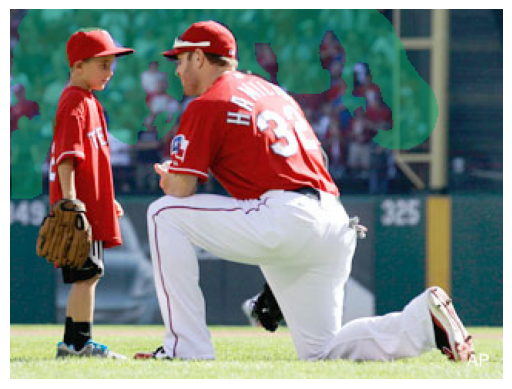

In [ ]:
catIds = coco.getCatIds(catNms=["people"])
annIds = coco.getAnnIds(catIds=catIds, iscrowd=True)
anns = coco.loadAnns(annIds[0:1])

dump_anns(anns)
img = coco.loadImgs(anns[0]["image_id"])[0]
I = coco2pil(img["coco_url"])
plt.imshow(I)
coco.showAnns(anns)  # People in the stands
seg = anns[0]["segmentation"]
print("Counts", len(seg["counts"]))
print("Size", seg["size"])
plt.axis("off")
plt.show()

[[video] 📺 COCO Dataset Format — Complete Walkthrough](https://www.youtube.com/watch?v=h6s61a_pqfM)

Используя методы из `pycocotools`, можно  преобразовать набор вершин "оболочки" сегментируемого объекта в более удобный, но менее компактный вид — маску объекта. Для этого будем пользоваться функцией `coco.annToMask`.

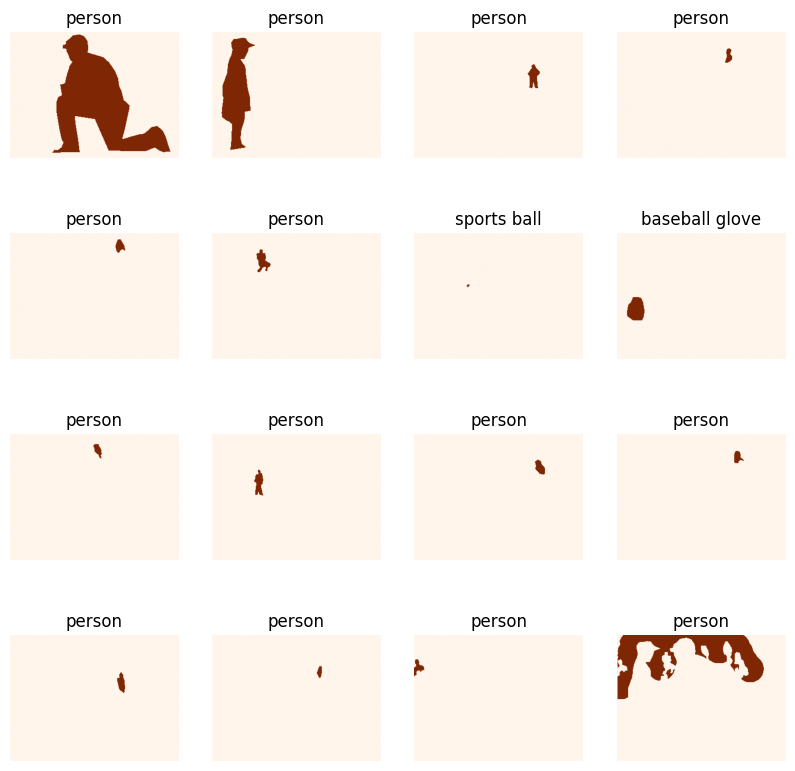

In [ ]:
import numpy as np

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)
msk = np.zeros(seg["size"])

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))


for i, ax in zip(range(16), axs.flat):
    msk = coco.annToMask(anns[i])
    ax.imshow(msk, cmap="Oranges")
    ax.set(title=num2cat[anns[i]["category_id"]])
    ax.axis("off")
plt.show()

Маска, выдаваемая этой функцией, — numpy-массив по размеру изображения, где 0 — отсутствие объекта в данном пикселе, 1 — наличие объекта.

Иногда попиксельная разметка изображения может быть избыточной.  Если необходимо посчитать **количество человек** на изображении, то достаточно как-то промаркировать каждого из них и посчитать количество "отметок". Вариантом маркировки является **выделение рамки** (bounding box), внутри которой находится объект. Такая информация об объектах также сохранена в аннотациях формата COCO.

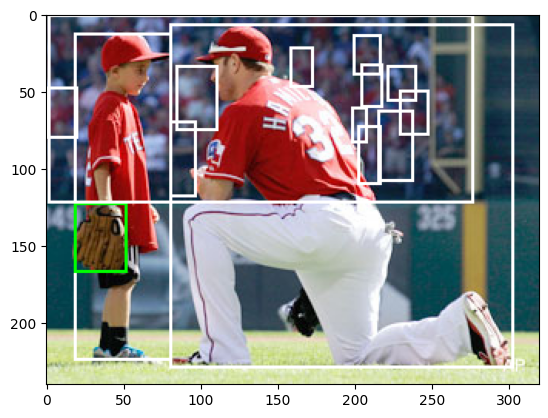

In [ ]:
from PIL import ImageDraw

annIds = coco.getAnnIds(imgIds=[448263])
anns = coco.loadAnns(annIds)
draw = ImageDraw.Draw(I)

colors = {1: "white", 40: "lime"}  # person - white, glove - lime
for ann in anns:
    x, y, width, heigth = ann["bbox"]  # bounding box here
    color = colors.get(ann["category_id"], None)
    if color:
        draw.rectangle((x, y, x + width, y + heigth), outline=color, width=2)
plt.imshow(I)
plt.show()

# Детектирование (Object detection)


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/detection.png" width="400"></center>

**Детектирование** — задача компьютерного зрения, в которой требуется **определить местоположение** конкретных **объектов** на изображении. Вычислять точные границы объектов не требуется, достаточно **определить ограничивающие прямоугольники (bounding boxes)**, в которых находятся объекты.


В общем случае:
- объекты могут принадлежать к **различным классам**,
- объектов каждого класса на изображении может **не быть** или **быть несколько**.

Детекция — одна из самых бурно развивающихся областей нейронных сетей. В рамках данной лекции мы рассмотрим **некоторые идеи и архитектуры**.

## Детектирование одного объекта

Начнём с **простой ситуации**. Нас интересуют объекты только одного класса. Мы знаем, что:
- объект **точно есть** на изображении,
- объект на изображении **только один**,
- объект на изображении **принадлежит к одному классу**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/one_object.png" width="500"></center>


**Вход модели**: изображение.

**Выход модели**: область (bounding box), в которой объект локализован, определяется набором координат вершин*.

\* *Если наложить условие, что стороны многоугольника должны быть параллельны сторонам изображения, то можно ограничиться предсказанием 2-х координат.*

### Предсказание координат

Задачу **предсказания координат bounding box** попробуем свести к задаче **регрессии**, т.к. мы **предсказываем набор чисел**.



В зависимости от требований эти числа могут нести разный смысл, например:

* координаты центра + ширина и высота,
* координаты правого верхнего и левого нижнего углов,
* координаты вершин многоугольника,
* ключевые точки (определение позы, распознавание лиц и т.д.),
* ...

Но в любом случае задача остается регрессионной.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/predict_key_points.png" width="700"></center>

<center><em>Примеры предсказывания точек</em></center>

<center><em>Sources: <a href="https://blog.roboflow.com/intro-to-computer-vision/">Introduction to Computer Vision</a>, <a href="https://www.researchgate.net/publication/269683682_Cascade_of_Forests_for_Face_Alignment">Cascade of Forests for Face Alignment</em></center>

**Простое решение** для этой задачи:

Берем сверточную сеть и меняем последний полносвязный слой таким образом, чтобы количество выходов совпадало с количеством координат, которые нам нужно предсказать.

Так для предсказания двух точек потребуется четыре выхода: ( x1, y1, x2, y2).




In [ ]:
import torch
from torch import nn
from torchvision.models import resnet18

torch.manual_seed(42)

# Load pretrained model
resnet_detector = resnet18(weights="ResNet18_Weights.DEFAULT")

# Change "head" to predict coordinates (x1,y1,x2,y2)
resnet_detector.fc = nn.Linear(resnet_detector.fc.in_features, 4)  # x1,y1,x2,y2

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.7MB/s]


Для обучения такой модели придется заменить функцию потерь на регрессионную, например, MSE.

In [ ]:
criterion = nn.MSELoss()

# This is a random example. Don't expect good results
input = torch.rand((1, 3, 224, 224))
target = torch.tensor([[0.1, 0.1, 0.5, 0.5]])  # x1,y1 x2,y2 or x,y w,h
print(f"Target: {target}")
output = resnet_detector(input)
loss = criterion(output, target)
print(f"Output: {output}")
print(f"Loss: {loss}")

Target: tensor([[0.1000, 0.1000, 0.5000, 0.5000]])
Output: tensor([[ 0.0432,  0.5333, -0.1924,  0.8475]], grad_fn=<AddmmBackward0>)
Loss: 0.19780877232551575


Координаты обычно предсказываются в процентах от длины и ширины изображения, для чего выходы модели нужно как-то нормализовать, например, добавив последним слоем сигмоиду:

In [ ]:
resnet_detector.fc = nn.Sequential(
    nn.Linear(resnet_detector.fc.in_features, 4), nn.Sigmoid()
)

resnet_detector(input)

tensor([[0.2782, 0.4618, 0.3732, 0.3802]], grad_fn=<SigmoidBackward0>)

По такому принципу работают многие модели для поиска различных ключевых точек.
Например, на лице (facial landmarks) или теле человека.

[[arxiv] 🎓 Recent Progress in Appearance-based Action Recognition (Humphreys et al., 2020)](https://arxiv.org/abs/2011.12619)

### Multitask loss

Координаты прямоугольников мы предсказывать научились. Теперь усложним задачу:
- объект **точно есть** на изображении,
- объект на изображении **только один**,
- объект на изображении может **принадлежать к разным классам**.

К задаче **локализации (регресии)** добавляется **классификация**.

Задачу классификации мы умеем решать:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/class_prediction.png" width="800"></center>

Остается объединить классификацию с регрессией:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/multitask_loss_0.png" width="800"></center>

Для этого нужно одновременно предсказывать:

* вероятность принадлежности к классам,
* координаты ограничивающего прямогульника (bounding box).

Тогда выход последнего слоя будет иметь размер $N + 4$, где $N$ — количество классов (1000 для ImageNet), а $4$ числа — это координаты одного bounding box ($(x1,y1,x2,y2)$ или $(x,y,w,h)$).

**Как описать функцию потерь для такой модели?**

Можно суммировать loss для классификации и loss для регрессии.

$$ \large L_\text{total} = L_\text{cross-entropy}+L_\text{mse}$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/multitask_loss.png" width="800"></center>

Однако значения разных loss могут иметь разные порядки, поэтому приходится подбирать весовые коэффициенты для каждого слагаемого.
В общем случае функция потерь будет иметь вид:

$$\large L_\text{total} = \sum _iw_iL_i,$$

где $w_i$ — весовые коэффициенты каждой из функций потерь. Они являются гиперпараметрами модели и требуют подбора.

### Подбор весов для loss




Можно подбирать веса компонентов loss в процессе обучения. Для этого к модели добавляется дополнительный слой:

[[arxiv] 🎓 Multi-Task Learning Using Uncertainty to Weigh Losses for Scene Geometry and Semantics (Alex Kendall et al., 2018)](https://arxiv.org/abs/1705.07115)

[[git] 🐾 Пример реализации MultiTask learning](https://github.com/Hui-Li/multi-task-learning-example-PyTorch/blob/master/multi-task-learning-example-PyTorch.ipynb)

## Детектирование нескольких объектов

Как быть, если объектов несколько? Как мы помним:

- объекты могут принадлежать к **различным классам**,
- объектов каждого класса на изображении может **не быть** или **быть несколько**.

Для каждого объекта нужно вернуть координаты $(x, y, w, h)$ и класс $(0 .. N)$.
Соответственно, количество выходов модели надо увеличивать.

Но нам неизвестно заранее, сколько объектов будет на изображении:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/object_detection_multiple_object.png" width="650"></center>

### Cкользящее окно

Одним из вариантов решения этой проблемы является применение классификатора ко всем возможным местоположениям объектов. Классификатор предсказывает, есть
ли на выбранном фрагменте изображения один из интересующих нас объектов. Если нет, то фрагмент классифицируется как "фон".

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/naive_way_object_detection_multiple_object.gif" width="700"></center>




Проблемой данного подхода является необходимость применять классификатор к огромному количеству различных фрагментов, что крайне дорого с точки зрения вычислений.

### Object proposal

Чтобы сократить количество возможных окон для детекции, использовали различные идеи:

1. **Использовать эвристику для нахождения потенциального положения объектов**. Области интереса (regions of interest — RoI) находятся с помощью алгоритма [Selective search 🎓[article]](https://ivi.fnwi.uva.nl/isis/publications/bibtexbrowser.php?key=UijlingsIJCV2013&bib=all.bib). Он разбивает картинку на мелкие кусочки, которые объединяет в области интереса, руководствуясь "похожестью" цвета, размера, текстуры и положения. Архитектура: Region-Based Convolutional Networks: [R-CNN 🎓[article]](https://ieeexplore.ieee.org/document/7112511).

2. **Заменить эвристический алгоритм для нахождения RoI на нейронную сеть**. Детектор состоит из 2-х ступеней: первая предполагает положение RoI (за один проход), вторая — предсказывает точные границы, есть ли там объект и к какой категории он относится (по одному проходу для каждого RoI). Архитектура: Two stage detectors:  [Faster R-CNN 🎓[arxiv]](https://arxiv.org/abs/1506.01497).

3. **Отказаться от двухступенчатой архитектуры**. Давайте заранее зададим центры и размеры окон (anchor), которые плотно покрывают все изображение/карты признаков.
Архитектуры: Single Shot Detector ([SSD 🎓[arxiv]](https://arxiv.org/abs/1512.02325)), You Only Look Once v2 ([YOLOv2 🎓[arxiv]](https://arxiv.org/pdf/1612.08242)).

4. **Отказаться от anchor**. Нейросеть предсказывает вероятность нахождения объекта и расстояния для границ его bounding box для каждой точки на карте признаков. Архитектура: Anchor free [FCOS 🎓[arxiv]](https://arxiv.org/abs/1904.01355).

5. **Взять ViT, делать предсказание для каждого patch**. Архитектура: [DETR 🎓[arxiv]](https://arxiv.org/abs/2005.12872).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/detector_types.png" width="1000">

**Общая схема работы детектора**:

* R-CNN: изображение $\xrightarrow{\text{Эвристика}}$ RoI $\xrightarrow{\text{CNN}}$ уточненный bounding box и его категория.
* Faster R-CNN: изображение $\xrightarrow{\text{Region proposal network}}$ RoI в пространстве признаков $\xrightarrow{\text{CNN}}$ уточненный bounding box и его категория.
* One stage: данные $\xrightarrow{\text{Статистика}}$ anchors,

    изображение + anchors $\xrightarrow{\text{CNN}}$ уточненные bounding boxes и их категории.
* Anchor free: изображение $\xrightarrow{\text{CNN}}$ bounding boxes и их категории.
* Transformer: изображение, разбитое на patch $\xrightarrow{\text{Transformer}}$ bounding boxes и их категории.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/detector_scheme.png" width="1000">

Loss складывается из loss для классификации $L_\text{conf}$ и loss для детекции $L_\text{loc}$:

$$\large L_\text{det} = L_\text{conf} + \alpha L_\text{loc}$$

При этом в $L_\text{loc}$ учитываются **не все** предсказанные bounding box, а только те, которые наилучшим образом пересекаются с GT (bbox из разметки). Фильтрация может проходить по порогу или при помощи алгоритма.

### Backbone, neck and head

Первые **детекторы** были похожи на **сети для классификации**.  Изображение проходило через последовательность сверточных слоев, которые извлекали признаки (backbone), на этих признаках делались предсказания (head).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/yolov1_architecture.png" width="1000"></center>

<center> Архитектура YOLOv1

Source: <a href ="https://arxiv.org/pdf/1506.02640">You Only Look Once: Unified, Real-Time Object Detection</a></center>



У такого подхода есть проблема. Он **хорош для обнаружения крупных объектов**, но плохо различает мелкие объекты на изображении. Эта проблема решена в современных детекторах. Для этого:
- используют **несколько "голов"** (head) детекции, которые работают с признаками разных размеров,
- используют **"шею"** (neck), в которой признаки разных размеров объединяются и перемешиваются.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/backbone_neck_head.png" width="900"></center>

<center><em>Backbone, neck и head в архитектуре YOLOv11 </em></center>

Итого:
- **Backbone** (хребет) — привычная нам пирамида для извлечения признаков (Feature Pyramid Network (FPN)),
- **Neck** (шея) — блок, который собирает признаки с разных уровней и перемешивает их,
- **Head** (голова) — принимает решение о наличии, положении и категории объекта.

### One-to-many vs one-to-one

Большинство детекторов учится в режиме one-to-many. К одному объекту с ограничивающим прямоугольником (bounding box) "притягиваются" сразу несколько объектов на выходе модели. Это дает [более устойчивое обучение 🎓[arxiv]](https://arxiv.org/pdf/2405.14458), т.к. ошибка усредняется по нескольким прямоугольникам.

Предсказание такого детектора требует постобработки.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/non_max_suppression.png" width="650"></center>

#### NMS

Есть несколько подходов к удалению лишних прямоугольников.
Наиболее известный — NMS (non-maximum suppression). Его задача — избавиться от bounding boxes, которые накладываются на истинный. Последовательность действий:

1. Из списка возможных bounding boxes выбирается прогноз с наибольшей уверенностью, что в нем расположен объект (confidence score). Этот bounding box добавляется в итоговый список и удаляется из исходного списка.
2. Для выбранного bounding box считается $\text{IoU}$ с каждым из списка возможных bounding boxes. Если $\text{IoU}$ больше порогового $\text{IoU}_{\text{threshold}}$ — bounding box удаляется из списка возможных (считается, что это bounding box для того же объекта, который добавлен в итоговый список).
3. Шаги 1–2 повторяются, пока список возможных bounding boxes не опустеет.

Значение $\text{IoU}_{\text{threshold}}$ является гиперпараметром.

При низком значении $\text{IoU}_{\text{threshold}}$ частично пересекающиеся объекты могут быть удалены. При высоком значениии $\text{IoU}_{\text{threshold}}$ для одного объекта может остаться несколько масок.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L11/out/non_max_suppression_pseudo_code.png" width="600"></center>
<center><em>Пример картинки, на которой NMS может работать некорректно</em></center>

В PyTorch алгоритм NMS доступен в модуле `torchvision.ops.nms` [🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html)
:

`torchvision.ops.nms(boxes, scores, iou_threshold)`,
где:
* `boxes` — массив bounding boxes,
* `scores` — предсказанные оценки,
* `iou_threshold` — порог IoU, NMS отбрасывает все перекрывающиеся поля с IoU > `iou_threshold`.

Существуют модификации алгоритма:
- [[arxiv] 🎓 Soft NMS](https://arxiv.org/pdf/1704.04503)
- [[arxiv] 🎓 Learnable NMS](https://arxiv.org/pdf/1705.02950)



## YOLO: You Only Look Once

Разбирая паттерны проектирования детекторов, мы несколько раз упомянули модель YOLO (you only look one). В настоящий момент можно сказать, что YOLO — это оптимальный детектор по соотношению **качества распознавания** к **скорости**.


Первая версия YOLO вышла в 2015 году (в том же году, что и SSD). На тот момент детектор несколько проигрывал SSD в точности. Однако благодаря усилиям **Джозефа Редмона** (Joseph Redmon) проект поддерживался и развивался в течение нескольких лет. Он возглавлял разработку YOLO до 3 версии.
 3-я версия детектора оказалась настолько удачной, что даже в 2021 можно было прочесть: ["YOLOv3, one of the most widely used detectors in industry" 🎓[arxiv]](https://arxiv.org/abs/2107.08430).



Последующие версии создавались разными авторами. Можно считать их разными форками YOLOv3, а не новыми версиями. Даже нумерация условна, например, статья про v7 датируется более ранней датой, чем v6.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/yolo_performance_comparison.png" width="1000"></center>

<center><em>Source: <a href="https://docs.ultralytics.com/models/yolo11/">Ultralytics YOLO11</a></em></center>

В прикладных задачах рекомендуется открыть последнюю версию документации библиотеки [Ultralytics 🛠️[doc]](https://docs.ultralytics.com/) и выбрать последнюю модель.

[[colab] 🥨 Подробнее про детекторы](https://colab.research.google.com/drive/1GWizPqYAZcYEn3yTvTSJsTzLBhVKjjza)

Мы же запустим одну из последних моделей.

Замечание: обратите внимание, что библиотека ultralytics имеет лицензию, ограничивающую коммерческое применение.

###YOLO-11 (2024)

Загрузим изображение:

In [ ]:
# Source: http://images.cocodataset.org/val2017/000000448263.jpg
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/000000448263.jpg

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00


In [ ]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/107.7 GB disk)


In [ ]:
from PIL import Image

img = Image.open("000000448263.jpg")

Модель можно скачать из репозитория [ultralytics 🛠️[doc]](https://docs.ultralytics.com/models/yolo-nas/). Инстанцируем модель по названию.

[[doc]🛠️ Полный список предобученных моделей](https://docs.ultralytics.com/models/)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")
model.info()

100%|██████████| 5.35M/5.35M [00:00<00:00, 87.0MB/s]


YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

Можем посмотреть на структуру модели.

In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

Детектируем объекты на изображении из COCO.

Из коробки модель работает с изображениями в разных форматах (даже url). Модель автоматически меняет размер входного изображения, возвращает объект с результатами. При этом предобработку (в т.ч. нормализацию) делать не требуется.

[[doc] 🛠️ Model Prediction with Ultralytics YOLO](https://docs.ultralytics.com/modes/predict/)

In [ ]:
results = model(img)


0: 480x640 3 persons, 3 baseball gloves, 363.8ms
Speed: 46.3ms preprocess, 363.8ms inference, 58.7ms postprocess per image at shape (1, 3, 480, 640)


В качестве [результата 🛠️[doc]](https://docs.ultralytics.com/modes/predict) возвращается список объектов, содержащих полную информацию о детектировании.

In [ ]:
print(len(results[0].boxes))  # contains detections for one image

6


У него есть [методы для получения списка координат 🛠️[doc]](https://docs.ultralytics.com/reference/results/) предсказанных bounding boxes после YOLOv11:

In [ ]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([35.,  0.,  0.,  0., 35., 35.])
conf: tensor([0.9154, 0.8292, 0.8229, 0.7766, 0.5910, 0.3562])
data: tensor([[ 16.8453, 123.0442,  54.9407, 170.0367,   0.9154,  35.0000],
        [ 86.4911,   6.9171, 301.0903, 230.6436,   0.8292,   0.0000],
        [ 88.3445,   7.0023, 228.2241, 231.8915,   0.8229,   0.0000],
        [ 19.9260,  11.4738,  79.8982, 227.2738,   0.7766,   0.0000],
        [150.3266, 178.6502, 178.5728, 210.0070,   0.5910,  35.0000],
        [270.9759, 180.8387, 302.1515, 229.3633,   0.3562,  35.0000]])
id: None
is_track: False
orig_shape: (240, 320)
shape: torch.Size([6, 6])
xywh: tensor([[ 35.8930, 146.5404,  38.0954,  46.9925],
        [193.7907, 118.7803, 214.5992, 223.7265],
        [158.2843, 119.4469, 139.8796, 224.8893],
        [ 49.9121, 119.3738,  59.9721, 215.8000],
        [164.4497, 194.3286,  28.2462,  31.3568],
        [286.5637, 205.1010,  31.1756,  48.5246]])
xywhn: tensor([[0.1122, 0.6

In [ ]:
image_prediction = results[0]

class_names = image_prediction.names
labels = image_prediction.boxes.cls
confidence = image_prediction.boxes.conf
bboxes_xyxy = image_prediction.boxes.xyxy
bboxes_xywh = image_prediction.boxes.xywh

print("Classes", class_names)
print("Predict labels", labels)
print("Predict confidence", confidence)
print("Labels shape", labels.shape)
print("Confidence  shape", confidence.shape)
print("BBoxes  shape", bboxes_xyxy.shape)

Classes {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68:

Координаты bounding boxes возвращаются в четырех вариантах:

- `xyxy` — абсолютные координаты верхнего левого и правого нижнего углов,
- `xywh` — абсолютные координаты центра, абсолютные ширина и высота,
- `xyxyn` — нормализованные координаты верхнего левого и правого нижнего углов,
- `xywhn` —  нормализованные координаты центра, ширина и высота.

In [ ]:
print(bboxes_xyxy)
print(bboxes_xywh)

tensor([[ 16.8453, 123.0442,  54.9407, 170.0367],
        [ 86.4911,   6.9171, 301.0903, 230.6436],
        [ 88.3445,   7.0023, 228.2241, 231.8915],
        [ 19.9260,  11.4738,  79.8982, 227.2738],
        [150.3266, 178.6502, 178.5728, 210.0070],
        [270.9759, 180.8387, 302.1515, 229.3633]])
tensor([[ 35.8930, 146.5404,  38.0954,  46.9925],
        [193.7907, 118.7803, 214.5992, 223.7265],
        [158.2843, 119.4469, 139.8796, 224.8893],
        [ 49.9121, 119.3738,  59.9721, 215.8000],
        [164.4497, 194.3286,  28.2462,  31.3568],
        [286.5637, 205.1010,  31.1756,  48.5246]])


Можно вызвать метод, который отрисует их на изображении:

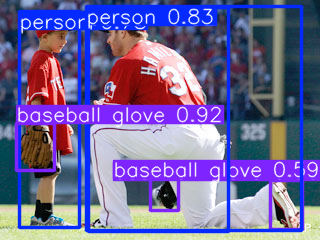

In [ ]:
results[0].show()

## Swin Transformer (2021)

[[arxiv] 🎓 Swin Transformer: Hierarchical Vision Transformer using Shifted Windows (Liu, Lin et al., 2021)](https://arxiv.org/abs/2103.14030)


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L10/out/cnn_fail.png" width="700"></center>



Применять ViT напрямую для задач сегментации и детектирования не эффективно, так как при **больших размерах patch** (16×16) не получится получить точные границы объектов, а при **уменьшении размеров patch** будет требоваться **все больше ресурсов**, так как сложность self-attention $O(n^{2})$ пропорциональна квадрату количества элементов на входе.

Авторы архитектуры Shifted Windows (Swin) Transfomer решают проблему при помощи трех усовершенствований:

1. **Self-attention** применяется не ко всему изображению сразу, а к его небольшим фрагментам — **окнам**:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/swin_vs_vit.png" width="600"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2103.14030.pdf">Swin Transformer: Hierarchical Vision Transformer using Shifted Windows</a></em></center>

2. **Окна** постоянно **сдвигаются**, это позволяет информации из разных окон перемешиваться:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/swin_window_shift.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2103.14030.pdf">Swin Transformer: Hierarchical Vision Transformer using Shifted Windows</a></em></center>



3. Строится пирамида признаков: окна объединяются в окна побольше.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L11/swin_architecture.png" width="1200"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2103.14030.pdf">Swin Transformer: Hierarchical Vision Transformer using Shifted Windows</a></em></center>

**Patch merging здесь** — это конкатенация эмбеддингов с последующей подачей на вход линейного слоя:

* Фрагменты из 4-х эмбеддингов 2×2×C конкатенируются. Получаем один тензор 1×1×4C.
* Подаем его на вход линейному слою, уменьшающему число каналов в 2 раза, получаем новый эмбеддинг размерностью 1×1×2C.

В отличие от традиционных трансформер-архитектур, размер embedding здесь меняется.

Такой подход позволил достичь SOTA результатов как в задаче классификации, так и в задачах детектирования и сегментации.
Авторы статьи позиционируют Swin Transformer как backbone решения широкого круга задач CV. В детекторе Swin Transformer выполняет функцию Backbone. Признаки разных размеров агрегируются для предсказания.

## Оценка качества детекции

В задаче детекции основной метрикой является mAP: **mean Average Precision**.

#### Precision & Recall

Вспомним формулы для Precision и Recall:

$$\large\displaystyle\mathrm{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$


$$\large\displaystyle\mathrm{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$

где $\text{TP}$ — True Positive, $\text{TN}$ — True Negative, $\text{FP}$ — False Positive, $\text{FN}$ — False Negative.

**Precision** (точность) — показывает, какая часть объектов, отнесенных моделью к положительному классу, действительно к нему относится. **Recall** (полнота) — показывает, какую долю объектов из положительного класса мы определили верно.

Разберемся, что это значит в контексте задачи детекции: мы пытаемся детектировать яблоки на фотографиях. Предположим, мы обработали 20 фотографий (на 10 фотографиях по одному яблоку и на 10 фотографиях яблок нет) и обнаружили, что:

* в 7 случаях наша нейросеть обнаружила яблоко там, где оно было на самом деле (**True Positive**);
* в 3 случаях не обнаружила яблоко там, где оно было (**False Negative**);
* в 4 случаях обнаружила яблоко там, где его не было (**False Positive**);
* в 6 случаях правильно определила, что на фотографии яблок нет (**True Negative**).



Посчитаем precision и recall:

In [ ]:
def precision(tp, fp):
    return tp / (tp + fp)


def recall(tp, fn):
    return tp / (tp + fn)


pres = precision(tp=7, fp=4)
rec = recall(tp=7, fn=3)

print(f"Precision = {pres:.2f}")
print(f"Recall = {rec:.2f}")

Precision = 0.64
Recall = 0.70


#### PR-кривая

Зная Precision и Recall для разных порогов, можно построить так называемую [PR-кривую ✏️[blog]](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

Для получения значений Precision и Recall требуются:

*  реальные метки,
*  предсказанные вероятности.

In [ ]:
import torch

y_true = torch.tensor([1, 1, 0])  # Labels
y_pred = torch.tensor([0.8, 0.1, 0.2])  # Predictions

Этого достаточно для того, чтобы построить PR-кривую для предсказаний одного класса.

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 10.0 MB/s eta 0:00:00


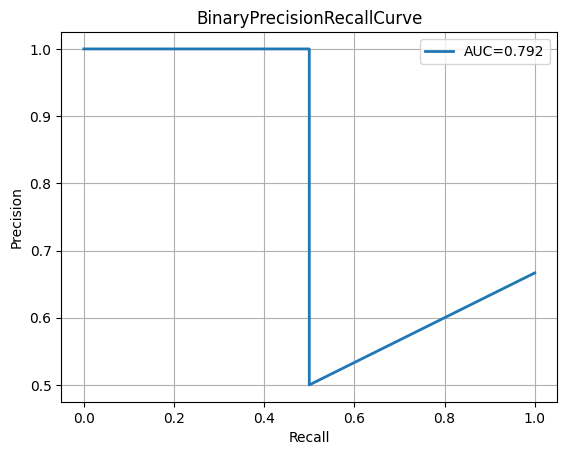

In [ ]:
from torchmetrics.classification import BinaryPrecisionRecallCurve

metric = BinaryPrecisionRecallCurve(thresholds=None)
metric(y_pred, y_true)
fig_, ax_ = metric.plot(score=True)

### Определение TP, FN и FP через IoU

При детектировании мы будем считать Average Precision для каждого класса отдельно. В данном примере сфокусируемся на яблоках.

Загрузим изображение из COCO. Выберем Ground True bounding box для категории яблоко из разметки:

In [ ]:
# Source: http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget -qN "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/annotations_trainval2017.zip"
!unzip -qn annotations_trainval2017.zip

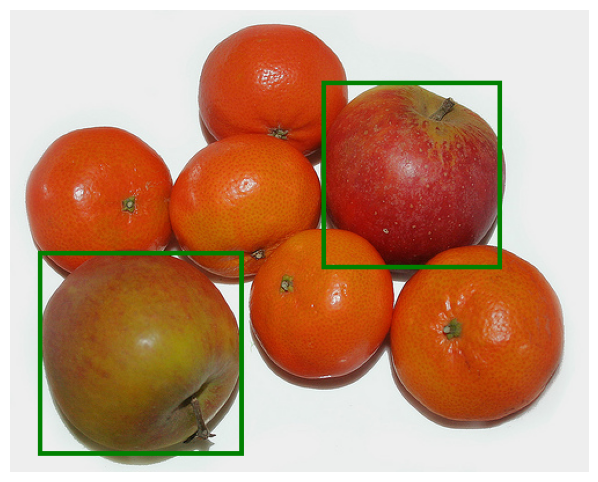

In [ ]:
import skimage

import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from IPython.display import clear_output
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes


def draw_bbox(img, bb_xywh, color):
    t_img = torch.tensor(img).permute(2, 0, 1)  # to tensor CHW
    xywh = torch.tensor(bb_xywh)[:, :4]  # take only coords
    bb = box_convert(xywh, "xywh", "xyxy")  # convert from COCO format
    img_with_bb = draw_bounding_boxes(t_img, bb, colors=color, width=4)
    return img_with_bb.permute(1, 2, 0).numpy()  # back to numpy HWC


coco = COCO("annotations/instances_val2017.json")
clear_output()

apples_img_id = 60855  # if of some image with apples
apple_cat_id = 53  # apple

ann_id = coco.getAnnIds(imgIds=[apples_img_id])
anns = coco.loadAnns(ann_id)

img_info = coco.loadImgs(apples_img_id)
img = skimage.io.imread(img_info[0]["coco_url"])

gt_bbox = []
for ann in anns:
    if ann["category_id"] == apple_cat_id:
        gt_bbox.append(ann["bbox"] + [ann["category_id"]])

img = draw_bbox(img, gt_bbox, "green")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
import pandas as pd

pd.DataFrame(data=gt_bbox, columns=["x", "y", "width", "height", "class_num"])

,x,y,width,height,class_num
0,269.44,61.96,154.91,161.48,53
1,24.26,208.04,177.04,176.13,53


Пусть детектор вернул результат в виде:

In [ ]:
import numpy as np

detections = np.array(
    [
        [290, 50, 170, 160, 0.7, 53],  # x, y, w, h, confidence, class_num
        [10, 200, 190, 180, 0.8, 53],
        [310, 250, 120, 130, 0.75, 53],
    ]
)
pd.DataFrame(
    data=detections, columns=["x", "y", "width", "height", "confidence", "class_num"]
)

,x,y,width,height,confidence,class_num
0,290.0,50.0,170.0,160.0,0.70,53.0
1,10.0,200.0,190.0,180.0,0.80,53.0
2,310.0,250.0,120.0,130.0,0.75,53.0


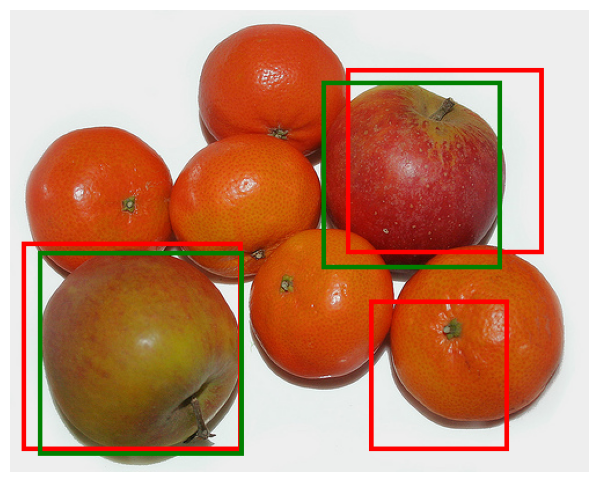

In [ ]:
img = skimage.io.imread(img_info[0]["coco_url"])
img = draw_bbox(img, detections, "red")
img = draw_bbox(img, gt_bbox, "green")
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

Мы можем выбрать порог $\text{IoU}_{\text{threshold}}$, по которому будем считать, что объект детектирован верно. Тогда:
* **True Positive** — сеть обнаружила яблоко там, где оно есть:
$\text{IoU} \ge \text{IoU}_{\text{threshold}}$, таких объектов 2.
* **False Negative** — сеть не обнаружила яблоко там, где оно было. Зеленый прямоугольник, для которого $\text{IoU} < \text{IoU}_{\text{threshold}}$, таких объектов нет.
* **False Positive** — сеть обнаружила яблоко там, где его не было. Красный прямоугольник, для которого $\text{IoU} < \text{IoU}_{\text{threshold}}$, такой объект 1.

Это эквивалентно тому, чтобы использовать условие $\text{IoU} \ge \text{IoU}_{\text{threshold}}$ вместо метки класса.

Преобразуем формат координат к `(x1, y1, x2, y2)`:

In [ ]:
gt = box_convert(torch.tensor(gt_bbox)[:, :4], "xywh", "xyxy")
pred = box_convert(torch.tensor(detections)[:, :4], "xywh", "xyxy")

Посчитаем $\text{IoU}$ для всех возможных пар предсказанных и истиных bounding boxes. Для этого воспользуемся функцией `torchvision.ops.box_iou` 🛠️[[doc]](https://pytorch.org/vision/main/generated/torchvision.ops.box_iou.html):



In [ ]:
from torchvision.ops import box_iou

pairwise_iou = box_iou(gt, pred)
print(pairwise_iou)

tensor([[0.6153, 0.0000, 0.0000],
        [0.0000, 0.8595, 0.0000]], dtype=torch.float64)


Выберем значение при максимальном пересечении для каждого предсказанного bounding box:

In [ ]:
iou, _ = pairwise_iou.max(dim=0)
print(iou)

tensor([0.6153, 0.8595, 0.0000], dtype=torch.float64)


Запишем эти значения в таблицу:


In [ ]:
predictions = torch.tensor(detections)[:, 4]
predictions = torch.vstack((predictions, iou)).T

pd.DataFrame(data=predictions, columns=["confidence", "iou"])

,confidence,iou
0,0.70,0.615274
1,0.80,0.859463
2,0.75,0.000000


Теперь будем использовать $\text{IoU} \ge \text{IoU}_{\text{threshold}}$ вместо метки класса, а confidence — вместо предсказанной вероятности. Будем считать, что если $\text{IoU}≥0.5$, то предсказание правильное.

In [ ]:
gt = iou > 0.5

predictions = torch.vstack((predictions[:, 0], gt)).T
detection_results = pd.DataFrame(data=predictions, columns=["confidence", "gt"])
detection_results.head()

,confidence,gt
0,0.70,1.0
1,0.80,1.0
2,0.75,0.0


Теперь у нас есть все необходимое для того, чтобы построить PR-кривую:

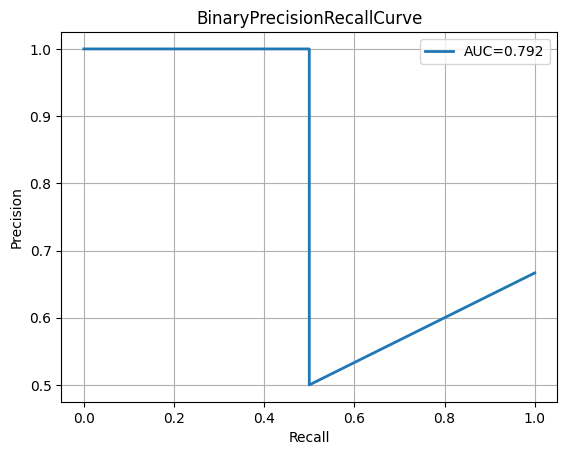

In [ ]:
y_pred = torch.tensor(detection_results["confidence"], dtype=torch.float)
y_true = torch.tensor(detection_results["gt"], dtype=torch.int)

metric = BinaryPrecisionRecallCurve(thresholds=None)
metric(y_pred, y_true)
fig_, ax_ = metric.plot(score=True)

### Average Precision

AP — это площадь под сглаженной PR-кривой.

$$\large \displaystyle AP = \int_0^1p(r)dr$$

Имея значения Precision и Recall, можно посчитать AP:

In [ ]:
from torchmetrics.classification import BinaryAveragePrecision


metric = BinaryAveragePrecision()
ap = metric(y_pred, y_true)
print(f"AveragePrecision = {ap:.2f}")

AveragePrecision = 0.83


При этом при расчете `PrecisionRecallCurve` мы получили значение 0.792. Дело в том, что при подсчете AP кривую сглаживают:

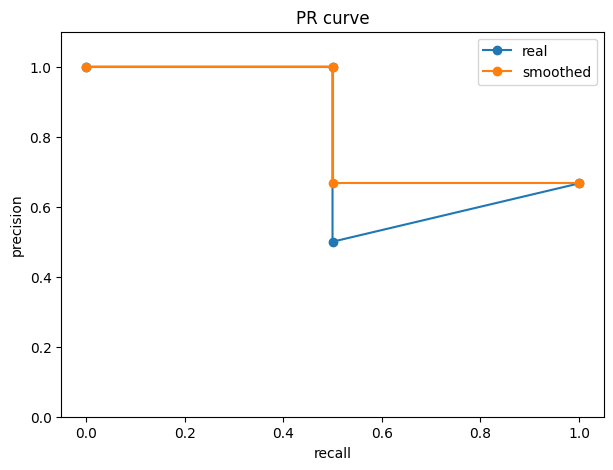

In [ ]:
from sklearn.metrics import precision_recall_curve


def smooth_precision(precision):
    smooth_prec = []
    for i in range(1, len(precision) + 1):
        max = precision[:i].max()
        smooth_prec.append(max)
    return smooth_prec


detection_results = detection_results.sort_values("confidence", ascending=False)
precision, recall, thresholds = precision_recall_curve(
    detection_results["gt"], detection_results["confidence"]
)

smoothed_precision = smooth_precision(precision)


plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker="o", label="real")
plt.plot(recall, smoothed_precision, marker="o", label="smoothed")
plt.ylim([0, 1.1])
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("PR curve")
plt.legend()
plt.show()

### mAP

Мы посчитали AP для одной категории, но в датасете их много.
Логично усреднить значения AP для разных категорий. В некоторых бенчмарках после такого усреднения к названию метрики добавляют приставку m (mean).

### AP для разных порогов

Мы выбрали для IoU порог 0.5.

Но можно посчитать AP для разных порогов, и затем тоже усреднить. В этом случае в названии метрики указываются минимальный и максимальный пороги.
Например `AP@[.5:.95]` соответствует среднему AP для IoU от 0.5 до 0.95 с шагом 0.05.

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

t_gt_bbox = torch.tensor(gt_bbox)
t_detections = torch.tensor(detections)

map_obj = MeanAveragePrecision("xywh", iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
results = map_obj(
    preds=[
        {
            "boxes": t_detections[:, :4],  # xywh
            "scores": t_detections[:, 4],  # confidence
            "labels": t_detections[:, 5].int(),  # class num
        }
    ],
    target=[
        {
            "boxes": t_gt_bbox[:, :4],
            "labels": t_gt_bbox[:, 4].int(),
        }  # xywh  # class num
    ],
)

print("mAP@[0.5:0.75] = ", results["map"].item())

mAP@[0.5:0.75] =  0.669966995716095
